In [1]:
import sys
print(sys.executable)

/usr/bin/python


In [3]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch


dataset ="50salads"
split = "test.split1.bundle"
default_path="./data/data/"
knowns = 14
unknowns = 5
prototypes = 30
video_dataset = VideoDataSet(dataset=dataset,
                               split=split,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
                               total_classes=knowns + prototypes)
data_loader = VideoDataLoader(video_dataset, batch_size=1, shuffle=True)

AssertionError: 

In [3]:
from model.bert import ActionBERT, ActionBERTConfig
import torch.nn.functional as F


prototypes = 30
bert_conf = ActionBERTConfig(
    total_classes=knowns + prototypes,
    input_dim=2048,
    d_model=256,
    num_heads=8,
    num_layers=6,
    dropout=0)
model = ActionBERT(config=bert_conf)
path = "./output/actionbert_second_try.pth"


state_dict = torch.load(path, map_location=torch.device('cuda'))
#model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Modell erfolgreich geladen.")

def get_model_pred(features,padding_mask):
    unknown_mask = torch.zeros_like(padding_mask).bool()
    print(unknown_mask)
    recon_feat, class_logits, boundaries  = model(features,unknown_mask,padding_mask)
    
    
    """pred_dist_start = torch.exp(boundaries[:, :, 0]) - 1
    pred_dist_end   = torch.exp(boundaries[:, :, 1]) - 1
   # pred_dist_start = torch.clamp(pred_dist_start, min=0)
    #pred_dist_end   = torch.clamp(pred_dist_end, min=0)
    
    B, T = pred_dist_start.shape
    device = pred_dist_start.device
    
   
    t_indices = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
    vote_start = torch.round(t_indices - pred_dist_start).long()
    vote_end   = torch.round(t_indices + pred_dist_end ).long()
    """
    softmax_logits = F.softmax(class_logits, dim=-1)  
    class_labels = torch.argmax(softmax_logits,dim=-1)
    print(class_labels.shape)
    return class_labels
    
    

Modell erfolgreich geladen.


In [4]:
for batch in data_loader:
    features = batch["features"]
    unknown_mask = batch["unknown_mask"]
    target_truth = batch["target_truth"]
    padding_mask = batch["padding_mask"]
    labels_dict = batch["labels_dict"]
    remap_dict = batch["remap_dict"]
    target_start = batch['target_start']
    target_end = batch['target_end']
   
   
   
   
    
    break

tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
torch.Size([1, 12371])
[42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42] [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12]
[12 12 12 ... 12 12 12]


/tmp/ipykernel_11100/3829971136.py:128: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


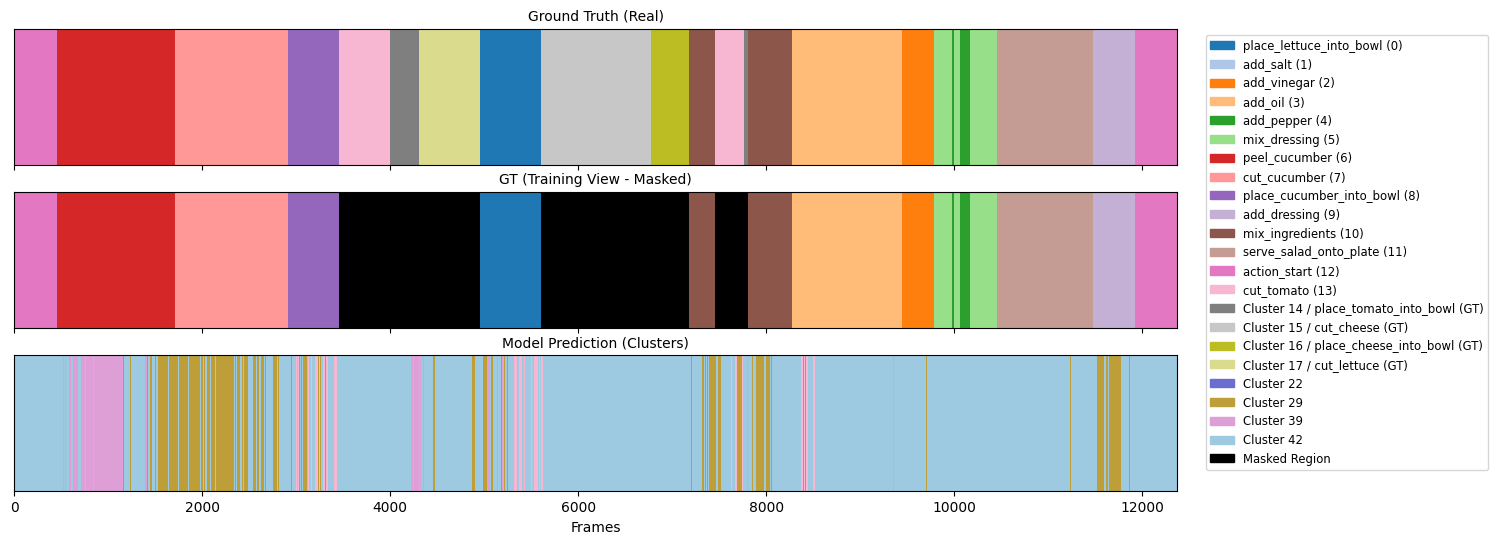

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# --- KONFIGURATION ---
NUM_KNOWNS = 14  # Anzahl Knowns (0-13)

# 1. Daten aus dem Batch holen
# Wir gehen davon aus, dass 'features', 'padding_mask', 'target_truth', etc. schon Variablen sind
# oder aus dem batch dict kommen.

# Model Prediction holen
res = get_model_pred(features.to('cuda'), padding_mask.to('cuda')).squeeze(0).cpu().numpy()

pad_mask_np = padding_mask.squeeze(0).cpu().numpy().astype(bool)
unknown_mask_np = unknown_mask.squeeze(0).cpu().numpy().astype(bool)
target_truth_np = target_truth.squeeze(0).cpu().numpy()

# Filtern (Padding weg)
target_truth_valid = target_truth_np[pad_mask_np]
unknown_mask_valid = unknown_mask_np[pad_mask_np]
res_valid = res[pad_mask_np]
print(res_valid[:20], target_truth_valid[:20])

# --- 2. ID-Mapping aus dem Batch nutzen (DER FIX) ---
# Du hast gesagt: remap_dict = batch["remap_dict"] (oder labels_dict)
# Dieses Dict ist wahrscheinlich: {'cut_tomato': 0, 'action_start': 12, ...}
# Wir brauchen es andersherum: {0: 'cut_tomato', 12: 'action_start'}

# Annahme: remap_dict ist das Dictionary aus deinem Batch
# Falls es im Batch ein Array/List ist (wegen Collate), nimm das erste Element.
raw_dict = batch["labels_dict"] # oder batch["remap_dict"]
if isinstance(raw_dict, list): # Falls Collate daraus eine Liste gemacht hat
    raw_dict = raw_dict[0]

# Umdrehen: ID -> Name
id_to_name = {v: k for k, v in raw_dict.items()}

# --- 3. Farb-Palette erstellen ---
max_id_gt = target_truth_valid.max()
max_id_pred = res_valid.max()
max_id_total = max(max_id_gt, max_id_pred)

# Farben stapeln
colors1 = plt.get_cmap('tab20').colors
colors2 = plt.get_cmap('tab20b').colors
colors3 = plt.get_cmap('tab20c').colors
base_colors = np.vstack((colors1, colors2, colors3))

# Palette erweitern falls nötig
while len(base_colors) <= max_id_total:
    base_colors = np.vstack((base_colors, base_colors))

# Schwarz für Masked GT am Ende anfügen
color_lut = base_colors[:max_id_total + 2].copy()
BLACK_ID = len(color_lut) - 1
color_lut[BLACK_ID] = [0.0, 0.0, 0.0] 

# --- 4. Plot-Daten vorbereiten ---

# GT Real: Zeigt alles in Farbe (auch die Unknowns, wie sie im Dataset heißen)
gt_full = target_truth_valid
print(gt_full)

# GT Masked: Zeigt Unknowns als Schwarz (Was das Modell "nicht weiß")
gt_masked = target_truth_valid.copy()
# Hier nutzen wir die unknown_mask vom Training -> Alles >= 14 wird schwarz
gt_masked[unknown_mask_valid] = BLACK_ID 

# Prediction: Zeigt Knowns (0-13) und gefundene Cluster (14+)
pred_full = res_valid 

plots_data = [
    ("Ground Truth (Real)", gt_full),      
    ("GT (Training View - Masked)", gt_masked),
    ("Model Prediction (Clusters)", pred_full) 
]

# --- 5. Plotten ---
fig, axs = plt.subplots(nrows=len(plots_data), ncols=1, figsize=(15, 6), sharex=True)
if len(plots_data) == 1: axs = [axs]

for i, (title, data_indices) in enumerate(plots_data):
    # Mapping ID -> RGB
    rgb_image = color_lut[data_indices]
    rgb_image = rgb_image[np.newaxis, :, :] 
    
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=10)
    axs[i].set_yticks([]) 
    if i == len(plots_data) - 1: axs[i].set_xlabel("Frames")

# --- 6. Legende (Jetzt 100% korrekt durch Dict) ---
patches = []

# A. Known Actions (IDs 0 bis NUM_KNOWNS-1)
# Wir iterieren durch 0..13 und schauen im Dict nach dem Namen
for i in range(NUM_KNOWNS):
    if i in id_to_name:
        name = id_to_name[i]
        color = color_lut[i]
        patches.append(mpatches.Patch(color=color, label=f"{name} ({i})"))

# B. Unknowns & Cluster
# Wir sammeln alle IDs, die > 13 sind und im Plot vorkommen
unique_ids_in_plot = np.unique(np.concatenate([gt_full, pred_full]))
unknown_ids = [uid for uid in unique_ids_in_plot if uid >= NUM_KNOWNS and uid != BLACK_ID]

for uid in sorted(unknown_ids):
    color = color_lut[uid]
    label = f"Cluster {uid}"
    
    # Wenn wir für diese ID einen Namen im GT haben, zeigen wir ihn an
    # (Das gilt für die IDs 14-18, die im GT vorkommen)
    if uid in id_to_name:
        real_name = id_to_name[uid]
        label += f" / {real_name} (GT)"
    
    patches.append(mpatches.Patch(color=color, label=label))

# C. Schwarz
patches.append(mpatches.Patch(color=[0,0,0], label="Masked Region"))

axs[0].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()